# Introduction

This notebook demonstrates how to use Haiku topic modeling framework for LDA sklearn topic modeling task. There are three steps described in the following implementations. 
1. preprocess raw documents using Haiku, and build a dataset containing necessary preprocessed data (i.e. text with stopword, without stopword, lemmatized text, tfidf, etc.) for later use.
2. run LDA sklearn algorithm with simple parameters, and choose the best # of topics from optimization process.
3. use LDA sklearn generated model for topic prediction and query of similar documents from the original corpus.
4. run topic trending over time with NMF model.

The process will generate pickled models (tfidf, w2v, NMF model), topic clouds, topic/keyword/doc matrix tables, and other visualized image files for post analysis.

#### supress warning messages

In [1]:
# -*- coding: utf-8 -*-
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
import os
import pandas as pd
import numpy as np
import pickle

# plotting
import webbrowser as wb
import pyLDAvis
import matplotlib
import matplotlib.pyplot as plt

# sklearn
from pprint import pprint
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# gensim
import gensim

# haiku
import haiku
from haiku.TextPreprocess import TextPreprocess
from haiku.topic_modeling.common import Dataset, build_dataset
import haiku.topic_modeling.common as tm_common
import haiku.topic_modeling.lda_sklearn as tm_lda_sklearn

### Text preprocessing:
1. detect langage, and only store english texts
2. remove punctuation, and unneeded code
3. To be investigated: replace with known correct words

However, removing stop words and lemmatizing texts will be done later, in a common function.

In [3]:
def preprocess_textfile(datadir, text_filename):
    tp = TextPreprocess()
    texts = []
    verbatim = pd.read_csv(os.path.join(datadir, text_filename + '.csv'), encoding = "ISO-8859-1")
    # generating following files for validation / debugging purpose
    output1 = os.path.join(datadir, text_filename + '_en1.csv')
    output2 = os.path.join(datadir, text_filename + '_en2.csv')
    output3 = os.path.join(datadir, text_filename + '_en3.csv')
    with open(output1, 'w', encoding='utf-16') as fw1, open(output2, 'w', encoding='utf-16') as fw2, open(output3, 'w', encoding='utf-16') as fw3:
        # this only applies to ASAT data
        dtime = []
        for i, row in enumerate(verbatim.values):
            if len(row) > 1:
                # assuming targeted text is the last column (or, the first column)
                text = row[len(row) - 1]
            else:
                text = row[0]
                
            lang = tp.detect_language(text)
            if lang == 'en':
                # convert to lower case and trim start/end
                text = text.strip().lower()

                fw1.write(text + '\n')
                if len(row) > 1:
                    dtime.append(row[0])

                text = tp.remove_punctuation(text)
                fw2.write(text + '\n')

                text = tp.replace_phrases(text)
                # supposed to cover this: text = text.replace('#N#', ' ')
                word_count = len(text.split())
                fw3.write(str(word_count) + '\t' + text + '\n')
                                            
                texts.append(text)
    return texts, dtime

### preprocess raw text

In [4]:
dataset_name = 'asat_verbatim_dtm'

# in notebook you have to use '__file__', instead of __file__
exepath = os.path.dirname(os.path.realpath('__file__'))
data_dir = os.path.join(exepath, 'data')

clean_texts_with_stopwords, dtime = preprocess_textfile(data_dir, dataset_name)
text_filename = os.path.join(data_dir, dataset_name + '_en1.csv')
raw_documents = []
with open(text_filename ,"r", encoding="utf-16") as fin:
    for line in fin.readlines():
        # convert to lowercase
        raw_documents.append(line.strip().lower())
print("Read %d raw text documents" % len(raw_documents))

Read 521 raw text documents


### initializing parameters

In [5]:
least_term_frequency = 20;

In [6]:
'''
define your own Vectorizer for feature extractions
'''
vec_model = TfidfVectorizer(analyzer='word',       
                                    min_df=least_term_frequency,                    # minimum reqd occurences of a word 
                                    stop_words="english",             # remove stop words, optional as it is supposed to be removed already
                                    lowercase=True,                   # convert all words to lowercase
                                    token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                                    # max_features=50000,             # max number of uniq words
                                    )

### Build data
In this function it will do removing stopwords, lemmatizing words, and create all necessary data sets for further processing or analysis

#### build_dataset function parameters:
    clean_texts_with_stopwords - from raw text, detected non-english documents are filtered out. In the English documents, punctuations and other speical text are removed.
    raw_documents - English documents closest to raw data
    data_dir - specified folder to store all output data
    dataset_name - specified output folder name
    vec_model - custom vectorizer function pointer, i.e. feature extraction functions
    w2v_model - custom word2vec model for coherence measurement, if "None", it uses existing input corpus to build w2v model
    least_term_frequency - minimum frequency of terms to be captured in dictionary
    initial_topics_k - starting number of topics

In [7]:
dataset = build_dataset(clean_texts_with_stopwords, raw_documents, data_dir, dataset_name, vec_model, None, least_term_frequency)

creating custom vectorizer...
Sparsicity:  7.970502070916254 %
Created 521 X 19 TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=20,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='[a-zA-Z0-9]{3,}', tokenizer=None, use_idf=True,
        vocabulary=None)-normalized document-term matrix
Vocabulary has 19 distinct terms
01. search (73.09)
02. result (44.33)
03. vkb (42.33)
04. article (33.93)
05. good (29.99)
06. use (26.33)
07. need (25.67)
08. case (25.26)
09. time (23.85)
10. information (23.50)
11. tool (23.48)
12. access (23.05)
13. work (19.93)
14. slow (18.86)
15. line (18.74)
16. make (17.50)
17. issue (16.14)
18. content (15.20)
19. relevant (14.70)
Model has 77 terms


### define custom parameters

In [8]:
if dtime != []:
    dataset.dtime = dtime

In [9]:
dataset.config = tm_common.Config()
dataset.config.kmin = 5
dataset.config.kmax = 10
dataset.config.kstep = 1

# experimenting with more paramters:
#  { 'init' : 'nndsvd', 'solver' : 'mu', 'beta_loss' : 'frobnius', 'max_iter' : 200, 'l1_ratio' : 0, 'alpha' : 0 }
# solver 'cd' does not handle beta_loss = 'kullback-leibler'
# beta_loss = 'kullback-leibler'. default beta_loss = 'frobenius'
# and other parameters specific to the topic modeling API

#Ensure this line has been declared: from sklearn.decomposition import NMF
# example(1)
#dataset.myfunc = NMF(init = 'nndsvd', n_components = 10, solver = 'mu', beta_loss = 'kullback-leibler')
#dataset.myfunc_optimization = lambda k: NMF(init = 'nndsvd', n_components = k, solver = 'mu', beta_loss = 'kullback-leibler')

# example(2)
#dataset.myfunc = lambda: NMF(init = None, n_components = 10, solver = 'cd', beta_loss='frobenius')
#dataset.myfunc_optimization = lambda k: NMF(init = None, n_components = k, solver = 'cd', beta_loss='frobenius')

In [10]:
def build_model(dataset):
    if dataset.myfunc == None:
        lda_model = LatentDirichletAllocation(n_topics = dataset.topics_k,         # Number of topics
                                          max_iter = 10,               # Max learning iterations
                                          learning_method = 'online',   
                                          random_state = 100,          # Random state
                                          batch_size = 128,            # n docs in each learning iter
                                          evaluate_every = -1,         # compute perplexity every n iters, default: Don't
                                          n_jobs = -1)                 # Use all available CPUs
    else:
        #print("run by customized LDA sklearn function")
        model = dataset.myfunc

    lda_output = lda_model.fit_transform(dataset.vectorized_data)
    return lda_model, lda_output

In [100]:
dataset.topics_k = 7
lda_model, lda_output = build_model(dataset)

In [101]:
lda_output

array([[0.14285714, 0.14285714, 0.14285714, ..., 0.14285714, 0.14285714,
        0.14285714],
       [0.07152946, 0.57114124, 0.07150329, ..., 0.0714297 , 0.07142863,
        0.07153907],
       [0.14285714, 0.14285714, 0.14285714, ..., 0.14285714, 0.14285714,
        0.14285714],
       ...,
       [0.05930189, 0.32651167, 0.05930179, ..., 0.05930253, 0.3769782 ,
        0.05930214],
       [0.07142861, 0.07142858, 0.07142858, ..., 0.07142888, 0.07142906,
        0.07142858],
       [0.07148276, 0.07155657, 0.57107171, ..., 0.07142898, 0.07142858,
        0.07160282]])

In [102]:
lda_output.shape

(521, 7)

In [33]:
filename =  os.path.join(dataset.data_dir, 'lda_sklearn_k%02d.model' % dataset.topics_k)
pickle.dump(lda_model, open(filename, 'wb'))

In [34]:
n_words = 10
filename =  os.path.join(dataset.data_dir, 'topWords_{k}topics_lda_sklearn.csv'.format(k=dataset.topics_k))
tm_common.print_top_words_sklearn(lda_model, dataset.keywords, n_words, filename)

filename =  os.path.join(dataset.data_dir, 'wordTopic_{k}topics_lda_sklearn.csv'.format(k=dataset.topics_k))
tm_common.get_topics(lda_model, dataset.vectorizer, dataset.topics_k, n_words).to_csv(filename, sep='\t')

In [104]:
dataset.vectorized_data.shape

(521, 19)

In [107]:
data = dataset.data_has_stopwords
lda_output = lda_model.fit_transform(dataset.vectorized_data)
# Create Document - Topic Matrix
# column names
topicnames = ["Topic" + str(i) for i in range(dataset.topics_k)]
print(topicnames)


['Topic0', 'Topic1', 'Topic2', 'Topic3', 'Topic4', 'Topic5', 'Topic6']


In [108]:
# index names
docnames = ["Doc" + str(i) for i in range(len(data))]
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']

In [110]:
df_topic_distribution

,Topic Num,Num Documents
0,0,178
1,1,86
2,2,68
3,6,65
4,3,65
5,5,59


In [40]:
#ToDo: fix error - TypeError: can't multiply sequence by non-int of type 'float'
#   at line: df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
df_topic_matrix = tm_common.create_topic_matrix_sklearn(lda_model, dataset.vectorized_data, dataset.data_has_stopwords)
filename =  os.path.join(dataset.data_dir, 'topicMatrix_{k}topics_lda_sklearn.csv'.format(k=dataset.topics_k))
df_topic_matrix.to_csv(filename, sep='\t')

In [47]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(dataset.vectorized_data))
# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(dataset.vectorized_data))

Log Likelihood:  -2054.1421869614796
Perplexity:  53.614259540214434


In [55]:
texts = tm_common.lemmatize_to_tokens(dataset.datalist_no_stopwords)
feat_names = dataset.vectorizer.get_feature_names()

k = dataset.topics_k

topics = []
for i in range(k):
    #for each topic, obtain the largest values, and add the words they map to into the dictionary.
    words_ids = lda_model.components_[i].argsort()[:-1 - n_words:-1]
    words = [feat_names[key] for key in words_ids]
    topics.append(words)

In [57]:
# Compute Coherence Score - higher, the better (?)
coherence_model_lda = gensim.models.CoherenceModel(
    topics = topics,
    texts = texts,
    dictionary = dataset.id2word,
    coherence='u_mass')
coherence_lda_umass = coherence_model_lda.get_coherence()
print('\nCoherence Score(u_mass): ', coherence_lda_umass)


coherence_model_lda = gensim.models.CoherenceModel(
    topics = topics,
    texts = texts,
    dictionary = dataset.id2word,
    coherence='c_v')

coherence_lda_cv = coherence_model_lda.get_coherence()
print('\nCoherence Score(c_v): ', coherence_lda_cv)

coherence_model_lda = gensim.models.CoherenceModel(
    topics = topics,
    texts = texts,
    dictionary = dataset.id2word,
    coherence='c_uci')
coherence_lda_uci = coherence_model_lda.get_coherence()
print('\nCoherence Score(c_uci): ', coherence_lda_uci)


Coherence Score(u_mass):  -4.040270336800342

Coherence Score(c_v):  0.28813472348664365

Coherence Score(c_uci):  -2.461361478793913


In [69]:
vis = pyLDAvis.sklearn.prepare(lda_model, dataset.vectorized_data, dataset.vectorizer)
pyLDAvis.save_html(vis, 'pyLDAvis_test_lda_sklearn.html')

In [76]:
filename = os.path.join(dataset.data_dir, 'pyldavis_{k}topics_lda_sklearn.html'.format(k=k))
'''
            Be aware of this parameter!
                sort_topics : sort topics by topic proportion (percentage of tokens covered). 
                Set to false to keep original topic order.
            '''
vis = pyLDAvis.sklearn.prepare(lda_model, dataset.vectorized_data, dataset.vectorizer)
pyLDAvis.save_html(vis, filename)

In [90]:
    #for i in range(dataset.topics_k):
    #    word_weights_per_topic = []
    #    print(i, lda_model.components_[i])
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        #words_ids = model.components_[i].argsort()[:- n_top_words - 1:-1]
        #words = [feat_names[key] for key in words_ids]
        
lda_model.components_.shape

(10, 19)

In [91]:
len(vocab)

19

In [111]:
W = lda_output
H = lda_model.components_
vocab = dataset.vectorizer.get_feature_names()
topic_summaries = tm_common.create_topic_summaries(H, vocab)
tm_common.visualize_clusters(W, topic_summaries, k, dataset, filename)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 521 samples in 0.001s...
[t-SNE] Computed neighbors for 521 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 521 / 521
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.542336
[t-SNE] Error after 1000 iterations: -0.260808
0 0.2984372079372406 -10.8123140335083 ['issue content relevant search information article time vkb make result']
1 35.97683334350586 -2.6907825469970703 ['vkb article search information make need work access use tool']
2 -52.547935485839844 -43.22376251220703 ['search need case line article information work time vkb result']
3 11.556264877319336 -60.45854949951172 ['tool use time line relevant access information search vkb content']
4 nan nan ['use make search line good need vkb case content article']
5 74.31175231933594 -35.7411003112793 ['good access slow tool vkb work article time information need']
6 13.927029609680176 64.07875823

ValueError: Out of range float values are not JSON compliant

In [87]:
W.shape, topic_summaries

((521, 10),
 ['slow issue information relevant search article time result vkb tool',
  'vkb search result article access information work need make good',
  'search need case result time article good relevant information vkb',
  'tool use time line relevant content result access work search',
  'good make content vkb article use line search tool time'])

### Run topics over time model 

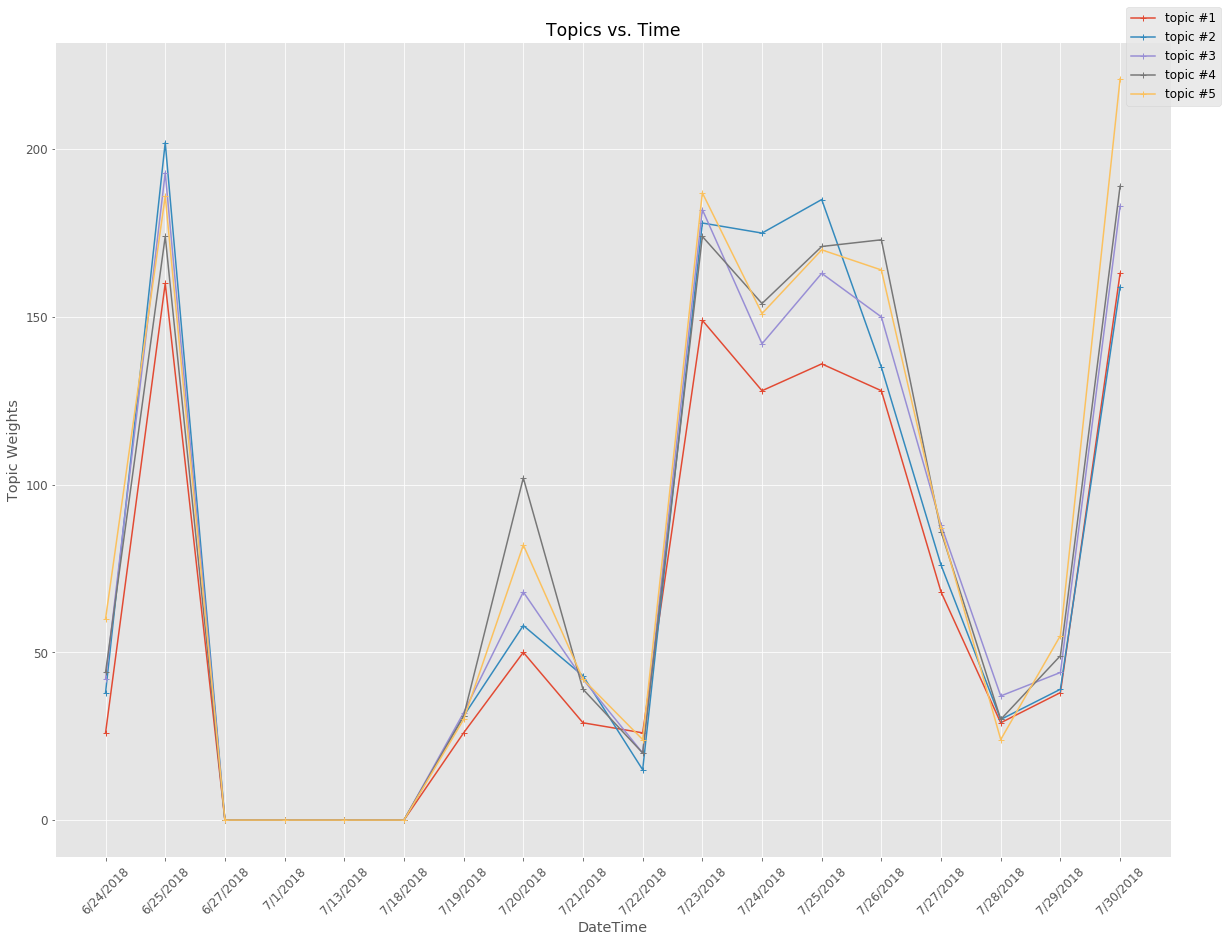

In [75]:
    import csv
    dataset.topics_k = 5
    lda_model = LatentDirichletAllocation(n_topics = dataset.topics_k,         # Number of topics
                                          max_iter = 10,               # Max learning iterations
                                          learning_method = 'online',   
                                          random_state = 100,          # Random state
                                          batch_size = 128,            # n docs in each learning iter
                                          evaluate_every = -1,         # compute perplexity every n iters, default: Don't
                                          n_jobs = -1)                 # Use all available CPUs

    w_matrix = lda_model.fit_transform(dataset.vectorized_data)
    dtm_data = tm_common.build_dtm(w_matrix, dataset.dtime)
    #alternative way
    #w_np = np.array(w_matrix)
    #dtime_np = np.array(dataset.dtime)
    #dtm_data = np.c_[dtime_np, w_np]
    filename = os.path.join(dataset.data_dir, 'dynamicTopicWeights_{k}topics_lda_sklearn.tsv'.format(k=dataset.topics_k))
    with open(filename, 'w') as fp:
        writer = csv.writer(fp, delimiter=',')
        writer.writerows(dtm_data)   
    
    plt = tm_common.visualize_dtm(np.array(dtm_data))
    filename = os.path.join(dataset.data_dir, 'dynamicTopicWeights_{k}topics_lda_sklearn.pdf'.format(k=dataset.topics_k))
    plt.savefig(filename, dpi=100)